In [13]:
from tqdm import tqdm
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import cv2
import torchvision.transforms as transforms

In [14]:
class CustomImageDataset(Dataset):
    def read_data_set(self):
        all_img_files = []
        all_mask_files = []

        img_lists = img_files = os.walk(self.img_path).__next__()[2]
        mask_lists = img_files = os.walk(self.mask_path).__next__()[2]

        print("Read imge data from " + self.img_path)
        task1 = tqdm(img_lists)

        for img_file in task1:
            img_file = os.path.join(self.img_path, img_file)
            img = cv2.imread(img_file, 0)
            if img is not None:
                all_img_files.append(img_file)
            else:
                print("ERROR : Not found " + img_file)

        print("Read mask data from " + self.mask_path)
        task2 = tqdm(mask_lists)

        for mask_file in task2:
            mask_file = os.path.join(self.mask_path, mask_file)
            mask = cv2.imread(mask_file, 0)
            if mask is not None:
                all_mask_files.append(mask_file)
            else:
                print("ERROR : Not found " + mask_file)

        print("\nNunber of image : " + str(len(all_img_files)))
        print("Nunber of mask : " + str(len(all_mask_files)))

        if len(all_img_files) != len(all_mask_files):
            print("\nERROR : Number of data mismatch")
        else:
            print("\nComplete!")

        return all_img_files, all_mask_files, len(all_img_files), len(all_mask_files)

    def __init__(self, img_path, mask_path, transforms=None):
        print("### Initialize Custom Dataset ###\n")

        self.img_path = img_path
        self.mask_path = mask_path
        self.image_files_path, self.mask_files_path, self.img_length, self.mask_length = self.read_data_set()
        self.transforms = transforms

        self.length = self.img_length

    def __getitem__(self, index):
        image = cv2.imread(self.image_files_path[index], 0)
        image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_CUBIC)
        mask = cv2.imread(self.mask_files_path[index], 0)
        mask = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_CUBIC)

        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)

        return {'image': image, 'mask': mask}

    def __len__(self):
        return self.length

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [16]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = CustomImageDataset(img_path="./data/image2", mask_path="./data/mask2", transforms=transform)

### Initialize Custom Dataset ###

Read imge data from ./data/image2
100%|██████████| 7232/7232 [00:07<00:00, 1023.70it/s]
Read mask data from ./data/mask2
100%|██████████| 7232/7232 [00:03<00:00, 1997.34it/s]

Nunber of image : 7232
Nunber of mask : 7232

Complete!


In [18]:
print(len(dataset))

7232


In [19]:
train_set, val_set = torch.utils.data.random_split(dataset, [6532, 700])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

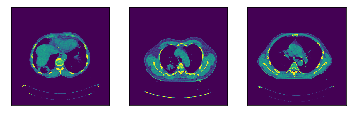

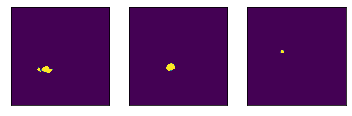

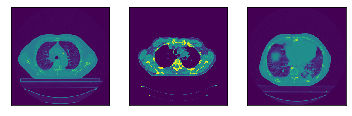

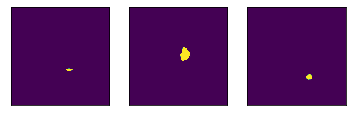

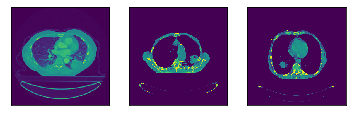

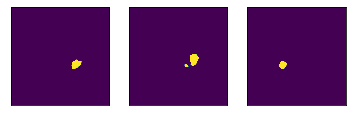

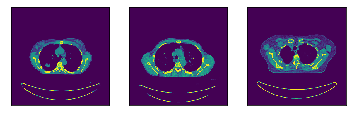

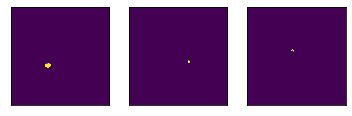

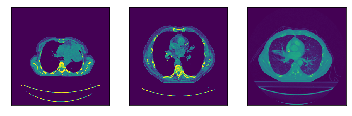

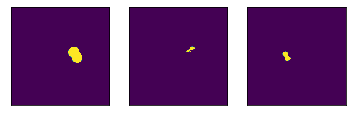

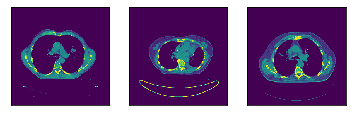

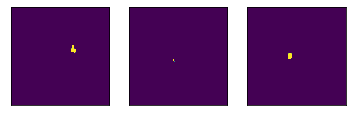

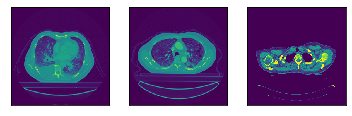

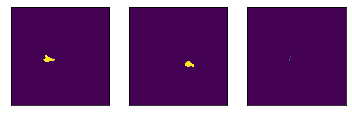

In [20]:
import matplotlib.pyplot as plt

plot_size = 3
plot_num = 5

for num, item in enumerate(train_loader):
    images = item['image']
    masks = item['mask']

    images = images.numpy()
    masks = masks.numpy()

    fig = plt.figure()

    for i in range(plot_size):
        ax = fig.add_subplot(1, plot_size, i + 1)
        image = images[i].squeeze()
        ax.imshow(image)
        ax.set_xticks([]), ax.set_yticks([])
        i += 1

    fig = plt.figure()

    for i in range(plot_size):
        ax = fig.add_subplot(1, plot_size, i + 1)
        image = masks[i].squeeze()
        ax.imshow(image)
        ax.set_xticks([]), ax.set_yticks([])
        i += 1

    if num > plot_num:
        break

In [21]:
def conv_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def conv_trans_block(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim,out_dim, kernel_size=3, stride=2, padding=1,output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool

def conv_block_2(in_dim,out_dim,act_fn):
    model = nn.Sequential(
        conv_block(in_dim,out_dim,act_fn),
        nn.Conv2d(out_dim,out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

In [22]:
class UnetGenerator(nn.Module):
    def __init__(self,in_dim,out_dim,num_filter):
        super(UnetGenerator,self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        self.down_1 = conv_block_2(self.in_dim,self.num_filter,act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1,self.num_filter*2,act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2,self.num_filter*4,act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4,self.num_filter*8,act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8,self.num_filter*16,act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16,self.num_filter*8,act_fn)
        self.up_1 = conv_block_2(self.num_filter*16,self.num_filter*8,act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8,self.num_filter*4,act_fn)
        self.up_2 = conv_block_2(self.num_filter*8,self.num_filter*4,act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4,self.num_filter*2,act_fn)
        self.up_3 = conv_block_2(self.num_filter*4,self.num_filter*2,act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2,self.num_filter*1,act_fn)
        self.up_4 = conv_block_2(self.num_filter*2,self.num_filter*1,act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter,self.out_dim,3,1,1),
            nn.Tanh(),
        )

    def forward(self,input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1,down_4],dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2,down_3],dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3,down_2],dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4,down_1],dim=1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

In [23]:
net = UnetGenerator(in_dim=1,out_dim=1,num_filter=16)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)

cuda:0


UnetGenerator(
  (down_1): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_2): Sequential(
    (0): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool_2): Max

In [25]:
import torch.optim as optim

criterion = nn.MSELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=8)

In [26]:
train_losses, val_losses, accuracy = [], [], []
epochs = 50
mini_batch = 100

for epoch in range(epochs):
    running_loss = 0
    val_loss = 0

    task = tqdm(train_loader)
    
    for i, data in enumerate(task):
        inputs, labels = data['image'].to(device), data['mask'].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % mini_batch == mini_batch - 1:
            with torch.no_grad():
                train_losses.append(running_loss/mini_batch)

                for j, val_data in enumerate(val_loader, 0):
                    val_image = val_data['image']
                    val_label = val_data['mask']
                    val_image, val_label = val_image.to(device), val_label.to(device)
                    val_outputs = net(val_image)
                                
                    val_loss += criterion(val_outputs, val_label)
                
                val_losses.append(val_loss/len(val_loader))
                lr_scheduler.step(val_loss/len(val_loader))

                task.set_description("Epoch %d || train loss %.6f || val loss %.6f" % (epoch+1, loss.item(), val_loss/len(val_loader)))

                running_loss = 0
                val_loss = 0

print('Finished Training')

Epoch 1 || train loss 0.004799 || val loss 0.004433: 100%|██████████| 205/205 [01:30<00:00,  2.26it/s]
Epoch 2 || train loss 0.003247 || val loss 0.003707: 100%|██████████| 205/205 [01:29<00:00,  2.29it/s]
Epoch 3 || train loss 0.003470 || val loss 0.003147: 100%|██████████| 205/205 [01:29<00:00,  2.29it/s]
Epoch 4 || train loss 0.002628 || val loss 0.002855: 100%|██████████| 205/205 [01:29<00:00,  2.29it/s]
Epoch 5 || train loss 0.002262 || val loss 0.002887: 100%|██████████| 205/205 [01:29<00:00,  2.29it/s]
Epoch 6 || train loss 0.002033 || val loss 0.002618: 100%|██████████| 205/205 [01:29<00:00,  2.29it/s]
Epoch 7 || train loss 0.001665 || val loss 0.002523: 100%|██████████| 205/205 [01:28<00:00,  2.32it/s]
Epoch 8 || train loss 0.001782 || val loss 0.002172: 100%|██████████| 205/205 [01:31<00:00,  2.25it/s]
Epoch 9 || train loss 0.001836 || val loss 0.002080: 100%|██████████| 205/205 [01:31<00:00,  2.24it/s]
Epoch 10 || train loss 0.001797 || val loss 0.002152: 100%|██████████| 20

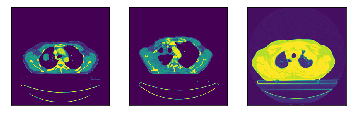

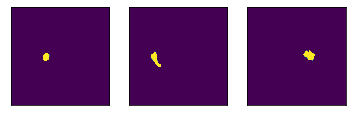

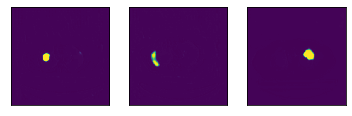

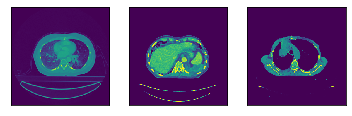

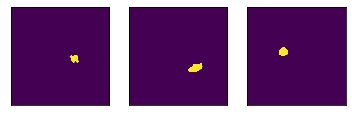

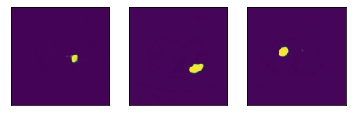

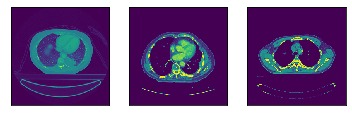

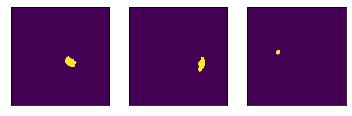

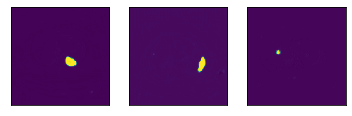

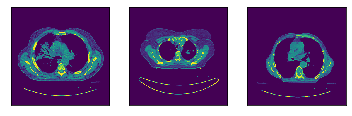

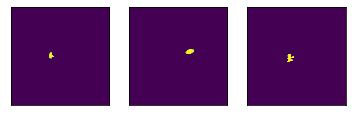

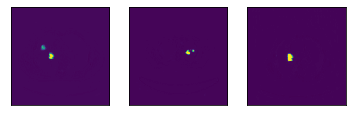

In [42]:
import matplotlib.pyplot as plt

plot_size = 3
plot_num = 2

a = b = c = 0

for num, item in enumerate(val_loader):
    images_tensor = item['image']
    masks_tensor = item['mask']

    inputs = images_tensor.to(device)
    outputs = net(inputs)
    show_out = outputs.detach().cpu().numpy()

    images = images_tensor.numpy()
    masks = masks_tensor.numpy()

    fig = plt.figure()

    for i in range(plot_size):
        ax = fig.add_subplot(1, plot_size, i + 1)
        image = images[i].squeeze()
        cv2.imwrite('./result/' + str(a) + '_' + str(b) + '_' + str(c) + '.jpg', image * 255)
        ax.imshow(image)
        ax.set_xticks([]), ax.set_yticks([])
        i += 1
        a += 1

    fig = plt.figure()

    for i in range(plot_size):
        ax = fig.add_subplot(1, plot_size, i + 1)
        image = masks[i].squeeze()
        cv2.imwrite('./result/' + str(a) + '_' + str(b) + '_' + str(c) + '.jpg', image * 255)
        ax.imshow(image)
        ax.set_xticks([]), ax.set_yticks([])
        i += 1
        b += 1

    fig = plt.figure()

    for i in range(plot_size):
        ax = fig.add_subplot(1, plot_size, i + 1)
        image = show_out[i].squeeze()
        cv2.imwrite('./result/' + str(a) + '_' + str(b) + '_' + str(c) + '.jpg', image * 255)
        ax.imshow(image)
        ax.set_xticks([]), ax.set_yticks([])
        i += 1
        c += 1

    if num > plot_num:
        break

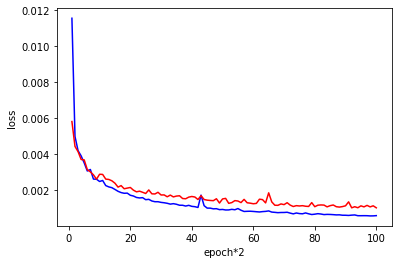

In [36]:
x = np.arange(1, 101, 1)

plt.plot(x, train_losses,'b', label='train loss')
plt.plot(x, val_losses,'r', label='val loss')
plt.xlabel('epoch*2')
plt.ylabel('loss')
plt.show()

In [43]:
PATH = './first.pth'
torch.save(net.state_dict(), PATH)